In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

Мы будем работать с данными агрегатора такси [Sigma Cabs](https://www.kaggle.com/datasets/arashnic/taxi-pricing-with-mobility-analytics). В зависимости от характеристик поездки требуется предсказать один из трех типов повышенного ценообразования: [1, 2, 3]. Таким образом, это поможет компании оптимально мэтчить такси и клиентов. 

In [2]:
df = pd.read_csv(os.path.dirname(os.path.dirname(os.getcwd())) + '/' + 'sigma_cabs.csv')
df.shape

(131662, 14)

In [3]:
# Занесем индекс колонку
df = df.set_index('Trip_ID')
df.head()

,Trip_Distance,Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Destination_Type,Customer_Rating,Cancellation_Last_1Month,Var1,Var2,Var3,Gender,Surge_Pricing_Type
Trip_ID,,,,,,,,,,,,,
T0005689460,6.77,B,1.0,2.42769,A,A,3.90500,0,40.0,46,60,Female,2
T0005689461,29.47,B,10.0,2.78245,B,A,3.45000,0,38.0,56,78,Male,2
T0005689464,41.58,NaN,10.0,NaN,NaN,E,3.50125,2,NaN,56,77,Male,2
T0005689465,61.56,C,10.0,NaN,NaN,A,3.45375,0,NaN,52,74,Male,3
T0005689467,54.95,C,10.0,3.03453,B,A,3.40250,4,51.0,49,102,Male,2


Описание признаков:

1. **Trip_ID**: ID for TRIP
2. **Trip_Distance**: The distance for the trip requested by the customer
3. **TypeofCab**: Category of the cab requested by the customer
4. **CustomerSinceMonths**: Customer using cab services since n months; 0 month means current month
5. **LifeStyleIndex**: Proprietary index created by Sigma Cabs showing lifestyle of the customer based on their behaviour
6. **ConfidenceLifeStyle_Index**: Category showing confidence on the indeX mentioned above
7. **Destination_Type**: Sigma Cabs divides any destination in one of the 14 categories.
8. **Customer_Rating**: Average of life time ratings of the customer till date
9. **CancellationLast1Month**: Number of trips cancelled by the customer in last 1 month
10. **Var1**, **Var2** and **Var3**: Continuous variables masked by the company. Can be used for modelling purposes
11. **Gender**: Gender of the customer

**SurgePricingType**: Target (can be of 3 types)


### EDA 
Заполните пропуски в вещественных признаках медианой, а в категориальных - самым популярным классом. Изобразите марицу корреляций и выведите топ5 пар самых коррелированных признаков.

Так как в сумме уникальных значений различных категориальных признаков окажется не супер-много, примените `One-Hot-Encoding` для них. Не забудьте в методе `pd.get_dummies` указать параметр `drop_first=True`.

In [4]:
### Your code is here
X = df.drop('Surge_Pricing_Type', axis=1)
y = df['Surge_Pricing_Type']

categorical_cols = X.dtypes[X.dtypes == object].index # such way
numeric_cols = X.loc[:, X.dtypes!=np.object].columns # or such way


# filling the gaps
X[numeric_cols] = X[numeric_cols].fillna(X[numeric_cols].median())

X[categorical_cols] = X[categorical_cols].fillna(X[categorical_cols].mode().iloc[0])

In [5]:
# checking which Encoding do we need to use
for col in categorical_cols:
    display(X[col].unique())

array(['B', 'C', 'E', 'D', 'A'], dtype=object)

array(['A', 'B', 'C'], dtype=object)

array(['A', 'E', 'B', 'C', 'G', 'D', 'F', 'K', 'L', 'H', 'I', 'J', 'M',
       'N'], dtype=object)

array(['Female', 'Male'], dtype=object)

Уникальных значений немного, можно использовать One-Hot везде

In [6]:
# one-hot encoding

X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)

In [7]:
# functions for top correlations
def get_top_correlations(df: pd.DataFrame, num: int) -> pd.DataFrame:
    """gets top correlations of dataframe""" 
    df = df.copy()
    df = df.corr().apply(abs).stack()
    
    # getting rid of self-correlation
    double_list = [col for col in df.index.to_list() if (col[0] == col[1])]
    df = df.drop(double_list, axis=0)
    
    # getting rid of mirror doubles
    no_dups_list = set([tuple(sorted(col)) for col in df.index.to_list()])
    df = df.loc[no_dups_list]
    
    df = df.sort_values(ascending=False)
    return df.iloc[0:num]

In [8]:
get_top_correlations(X, 5)

Var2                           Var3                             0.683437
Confidence_Life_Style_Index_B  Confidence_Life_Style_Index_C    0.565692
Life_Style_Index               Trip_Distance                    0.468332
Type_of_Cab_B                  Type_of_Cab_C                    0.416698
                               Type_of_Cab_D                    0.328262
dtype: float64

### Training

In [9]:
np.random.seed(2022)

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [10]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

**Задание 1.** Обучите One-vs-Rest Logreg. Не забудьте в шаг добавить стандартизацию данных (через `StandardScaler`) Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg. Здесь и далее округляйте до 3 знака после запятой.

Чтобы отдельно и долго не вычислять метрики, можно воспользоваться `classification_report` из `sklearn.metrics`!

In [11]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### Your code is here
pipe = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_rest', OneVsRestClassifier(LogisticRegression()))])
pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.723     0.542     0.619      5372
           2      0.636     0.834     0.722     11349
           3      0.741     0.571     0.645      9612

    accuracy                          0.679     26333
   macro avg      0.700     0.649     0.662     26333
weighted avg      0.692     0.679     0.673     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()` из предложенных. Для лучшего набора гиперпараметров посчитайте те же самые метрики. Валидировать параметры необходимо по `accuracy`. В этот раз проведем настояющую процедуру Кросс-Валидации! 

Для этого в метод `fit` передадим тренировочную часть наших данных, в параметр `cv` ничего не будем передавать (по дефолту 5-fold Кросс-Валидация будет проведена), а итоговые метрики замерим на тесте!

In [12]:
param_grid = {'one_vs_rest__estimator__penalty': ['l1', 'l2', 'elasticnet'],
              'one_vs_rest__estimator__C': [0.001, 0.01, 0.1, 1]}

In [13]:
### Your code is here

from sklearn.model_selection import GridSearchCV

search = GridSearchCV(pipe, param_grid, scoring='accuracy', return_train_score=True)
search.fit(X_train, y_train)

search.best_params_

{'one_vs_rest__estimator__C': 0.001, 'one_vs_rest__estimator__penalty': 'l2'}

In [14]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.742     0.534     0.621      5372
           2      0.635     0.839     0.723     11349
           3      0.742     0.576     0.649      9612

    accuracy                          0.681     26333
   macro avg      0.706     0.650     0.664     26333
weighted avg      0.696     0.681     0.675     26333



Изобразите три калибровочные кривые для Logistic Classifier: 0-vs-rest, 1-vs-rest, 2-vs-rest. Хорошо ли откалиброван обученный классификатор? 

Заметьте, что `predict_proba` возвращает список из вероятностей для всех наших классов!

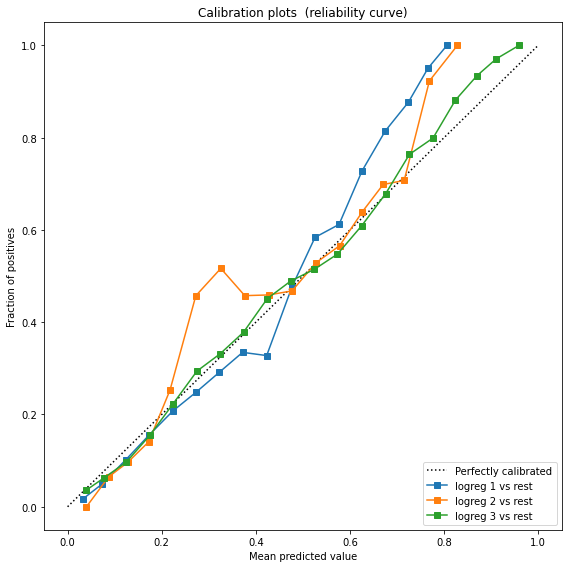

In [15]:
### Your code is here

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve


### Your code is here
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 1, y_test, 0), search.predict_proba(X_test)[:, 0], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 1 vs rest")

fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 2, y_test, 0), search.predict_proba(X_test)[:, 1], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 2 vs rest")

fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 3, y_test, 0), search.predict_proba(X_test)[:, 2], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 3 vs rest")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

**Задание 2.** Обучите логистическую регрессию с гиперпараметрами из первого задания на полиномиальных признаках до 4 степени. Сравните метрики с первым заданием.


Пример: Пусть у нас был единственный признак 

$$
d_j = [1, 2, 3, 4]
$$

Тогда полиномиальные признаки до 4 степени от такого будут иметь вид:

$$
d_j^1 = [1, 2, 3, 4]
$$

$$
d_j^2 = [1, 4, 9, 16]
$$

$$
d_j^3 = [1, 8, 27, 64]
$$

$$
d_j^4 = [1, 16, 81, 256]
$$

P.S. Бинарные колонки нет смысла возводить в какие-то степени, поэтому возьмем исключительно вещественные из базовых. 

Для этого можно воспользоваться классическим циклом (или уроком из занятия про `Sberbank Housing Market`). Положите модифицированный датасет в переменную `X_polinomial`!

P.S.S Зачастую еще, создаваю полиномиальные фичи, учитывают "пересечения" признаков, то есть, например, из векторов признаков $d_j, d_i$ генерируют не просто новые степени $d_j^2, d_i^2, d_j^3, d_i^3...$, а еще и признаки вида $d_j \cdot d_i, d_j^2 \cdot d_i, d_j \cdot d_i^2...$, но здесь ограничьтесь просто степенями!

In [16]:
### Создание полиномиальных признаков

X_polinomial = X.copy()


### Your code is here

for col in numeric_cols:
    for i in range(2, 5):
        X_polinomial[col + '_' + str(i)] = X_polinomial[col] ** i
       

Index(['Trip_Distance', 'Customer_Since_Months', 'Life_Style_Index',
       'Customer_Rating', 'Cancellation_Last_1Month', 'Var1', 'Var2', 'Var3',
       'Type_of_Cab_B', 'Type_of_Cab_C', 'Type_of_Cab_D', 'Type_of_Cab_E',
       'Confidence_Life_Style_Index_B', 'Confidence_Life_Style_Index_C',
       'Destination_Type_B', 'Destination_Type_C', 'Destination_Type_D',
       'Destination_Type_E', 'Destination_Type_F', 'Destination_Type_G',
       'Destination_Type_H', 'Destination_Type_I', 'Destination_Type_J',
       'Destination_Type_K', 'Destination_Type_L', 'Destination_Type_M',
       'Destination_Type_N', 'Gender_Male', 'Trip_Distance_2',
       'Trip_Distance_3', 'Trip_Distance_4', 'Customer_Since_Months_2',
       'Customer_Since_Months_3', 'Customer_Since_Months_4',
       'Life_Style_Index_2', 'Life_Style_Index_3', 'Life_Style_Index_4',
       'Customer_Rating_2', 'Customer_Rating_3', 'Customer_Rating_4',
       'Cancellation_Last_1Month_2', 'Cancellation_Last_1Month_3',
       

In [17]:
X_pol_train, X_pol_test, y_train, y_test  = train_test_split(X_polinomial, y, 
                                                             test_size=0.2, 
                                                             shuffle=True, 
                                                             random_state=2022)

In [19]:
### Your code is here

from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

### Your code is here
pipe_pol = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_rest', OneVsRestClassifier(LogisticRegression(C=0.001, penalty='l2')))])
pipe_pol.fit(X_pol_train, y_train)

print(classification_report(y_test, pipe_pol.predict(X_pol_test), digits=3))

              precision    recall  f1-score   support

           1      0.748     0.532     0.622      5372
           2      0.636     0.837     0.723     11349
           3      0.741     0.584     0.653      9612

    accuracy                          0.682     26333
   macro avg      0.708     0.651     0.666     26333
weighted avg      0.697     0.682     0.677     26333



По аналогии с первым заданием изобразите три калибровочные кривые. Стало ли лучше?

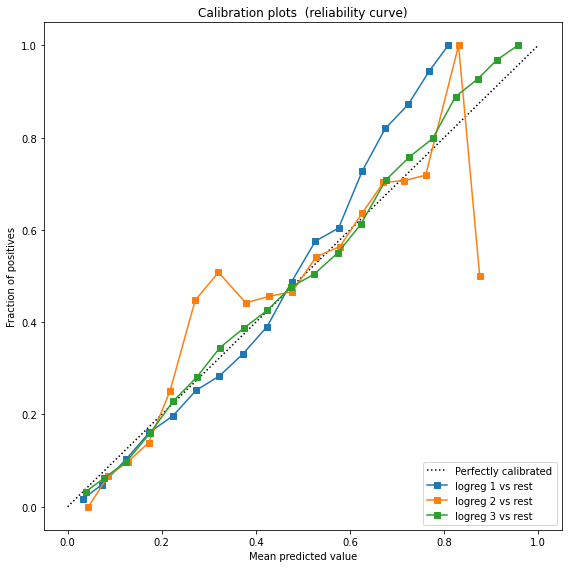

In [21]:
### Your code is here

import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve

### Your code is here
plt.figure(figsize=(8, 8))
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

### Предсказания модели на тесте и соответствующая калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 1, y_test, 0), pipe_pol.predict_proba(X_pol_test)[:, 0], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 1 vs rest")

fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 2, y_test, 0), pipe_pol.predict_proba(X_pol_test)[:, 1], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 2 vs rest")

fraction_of_positives, mean_predicted_value = calibration_curve(np.where(y_test == 3, y_test, 0), pipe_pol.predict_proba(X_pol_test)[:, 2], n_bins=20)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="logreg 3 vs rest")

plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.ylim([-0.05, 1.05])
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.tight_layout()

**Задание 3.** Обучите на датасете без полиномиальных признаков One-vs-One `SGDClassifier` из `sklearn.linear_model`, который использует стохастический градиентный спуск (узнаете о нем позже) и может обучать как `SVM`, так и, например, `LogReg`, если указать в качестве параметра `loss` либо `hinge`, либо `log` соответственно!

Посчитайте precision, recall, f1-score и усредните по всем классам с помощью micro, macro и weighted avg.

In [22]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, 
                                                     test_size=0.2, 
                                                     shuffle=True, 
                                                     random_state=2022)

In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsOneClassifier

### Your code is here
pipe_ovo = Pipeline([('scaler', StandardScaler()),
                 ('one_vs_one', OneVsOneClassifier(SGDClassifier()))])
pipe_ovo.fit(X_train, y_train)

print(classification_report(y_test, pipe_ovo.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.733     0.533     0.617      5372
           2      0.625     0.868     0.727     11349
           3      0.761     0.529     0.624      9612

    accuracy                          0.676     26333
   macro avg      0.707     0.643     0.656     26333
weighted avg      0.697     0.676     0.667     26333



Подберите оптимальные гиперпараметры модели с помощью `GridSearchCV()`. При этом переберите всевозможные функции потерь. Таким образом, при `loss = 'hinge'`, мы обучим SVM, при `loss = 'log'` мы обучим логистическую регрессию и т.д.

Используйте прием с Кросс-Валидацией при подборе параметров, как ранее, а также замерьте метрики на тесте.

In [27]:
param_grid = {'one_vs_one__estimator__loss': ['hinge', 'log', 'modified_huber'],
              'one_vs_one__estimator__penalty': ['l1', 'l2'],
              'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1]}

In [28]:
### Your code is here
search = GridSearchCV(pipe_ovo, param_grid, scoring='accuracy', return_train_score=True)
search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('one_vs_one',
                                        OneVsOneClassifier(estimator=SGDClassifier()))]),
             param_grid={'one_vs_one__estimator__alpha': [0.001, 0.01, 0.1],
                         'one_vs_one__estimator__loss': ['hinge', 'log',
                                                         'modified_huber'],
                         'one_vs_one__estimator__penalty': ['l1', 'l2']},
             return_train_score=True, scoring='accuracy')

In [29]:
print(classification_report(y_test, search.predict(X_test), digits=3))

              precision    recall  f1-score   support

           1      0.746     0.530     0.620      5372
           2      0.631     0.848     0.724     11349
           3      0.747     0.566     0.644      9612

    accuracy                          0.680     26333
   macro avg      0.708     0.648     0.662     26333
weighted avg      0.697     0.680     0.673     26333



Можно ли однозначно сказать, какой подход оказался лучше: One-vs-Rest или One-vs-One?